In [1]:
import os
from os.path import expanduser, join, basename, dirname
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, mapping
import contextily as ctx
import ulmo
import rasterio as rio
from rasterio.features import dataset_features
from rasterio.mask import mask
from shapely.ops import unary_union
from conversion import imperial_to_metric
from rasterio.windows import Window
from shapely.geometry import mapping
import pickle
from ulmo_extract import get_snotel_image_results
from rio_geom import rio_to_exterior

In [2]:
#This is the latest CUAHSI API endpoint
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [3]:
import ee
ee.Authenticate()
# Initialize the Earth Engine module.
ee.Initialize()


Successfully saved authorization token.


In [ ]:
def atmospheric_h20_diff(img_fp, ann_fp):
    with rio.open(img_fp) as src:
        arr = src.read(1)
        bounds = src.bounds
        geom = ee.Geometry.BBox(*bounds)
        df = pd.read_csv(ann_fp, index_col = [0])
        s = pd.to_datetime(df.loc['value','start time of acquisition for pass 1']).tz_localize(None)
        e = pd.to_datetime(df.loc['value','start time of acquisition for pass 2']).tz_localize(None)
        try:
            atmospheric_h20 = ee.ImageCollection("NCEP_RE/surface_wv").select('pr_wtr').filterDate(s,e)
            atmospheric_f1 = atmospheric_h20.limit(1, 'system:time_start', True).first().reduceRegion(reducer=ee.Reducer.mean(), geometry=geom).get('pr_wtr').getInfo()
            atmospheric_f2 =  atmospheric_h20.limit(1, 'system:time_start', False).first().reduceRegion(reducer=ee.Reducer.mean(), geometry=geom).get('pr_wtr').getInfo()
            h20_diff = atmospheric_f2 - atmospheric_f1
            return h20_diff
        except ee.ee_exception.EEException as e:
            print(e)

-0.08275884595410599


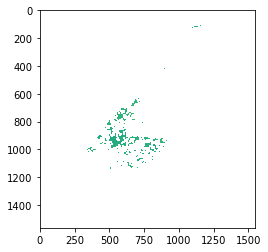

-5.968000373840334


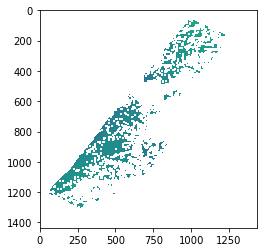

4.837931139715787


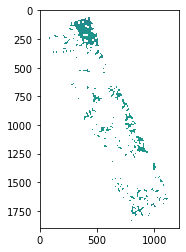

-2.366667005750868


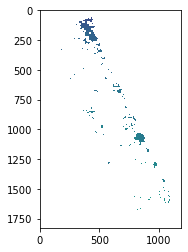

0.6666665077209464


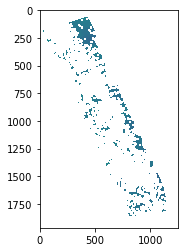

-1.0666664794639296


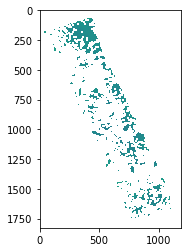

-1.9000000953674316


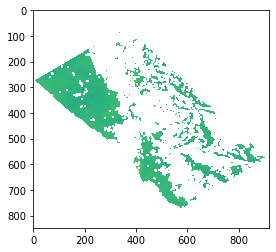

0.0


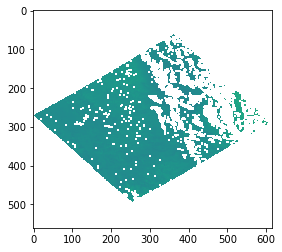

-1.7000000476837158


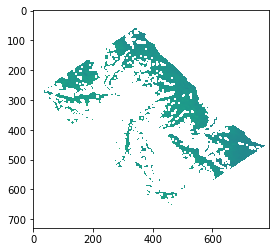

3.5999999046325684


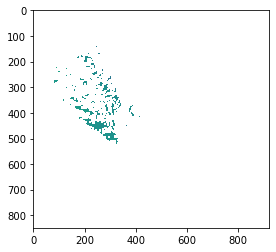

In [37]:
for i in range(10):
    img_fp = image_fps[i]['fp']
    ann_fp = image_fps[i]['ann']
    with rio.open(img_fp) as src:
        arr = src.read(1)
        bounds = src.bounds
        geom = ee.Geometry.BBox(*bounds)
        df = pd.read_csv(ann_fp, index_col = [0])
        s = pd.to_datetime(df.loc['value','start time of acquisition for pass 1']).tz_localize(None)
        e = pd.to_datetime(df.loc['value','start time of acquisition for pass 2']).tz_localize(None)
        try:
            atmospheric_h20 = ee.ImageCollection("NCEP_RE/surface_wv").select('pr_wtr').filterDate(s,e)
            atmospheric_f1 = atmospheric_h20.limit(1, 'system:time_start', True).first().reduceRegion(reducer=ee.Reducer.mean(), geometry=geom).get('pr_wtr').getInfo()
            atmospheric_f2 =  atmospheric_h20.limit(1, 'system:time_start', False).first().reduceRegion(reducer=ee.Reducer.mean(), geometry=geom).get('pr_wtr').getInfo()
            h20_diff = atmospheric_f2 - atmospheric_f1
            print(h20_diff)
            plt.imshow(arr[::10,::10], vmax = 3*np.pi, vmin = -3*np.pi)
            plt.show()
        except ee.ee_exception.EEException as e:
            print(e)

In [30]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
image_fps = [i for i in image_fps if 'L090VH_' in i['fp']]

In [ ]:
image_fps = [i for i in image_fps if 'L090VH_' in i['fp']]
for i in range(40):
    snow_off_phase_check(image_fps[i]['fp'],image_fps[i]['ann'])